# Livrable 1 - Classification binaire

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np
import os
import random

In [16]:
base_dir = os.getcwd()  
dataset_dir = os.path.join(base_dir, 'DataSets', 'data_set_livrable_1')

In [19]:
def count_images_in_folder(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

painting_path = os.path.join(dataset_dir, 'image', 'Painting')
schematics_path = os.path.join(dataset_dir, 'image', 'Schematics')
sketch_path = os.path.join(dataset_dir, 'image', 'Sketch')
photo_path = os.path.join(dataset_dir, 'Photo')


num_paintings = count_images_in_folder(painting_path)
num_schematics = count_images_in_folder(schematics_path)
num_sketches = count_images_in_folder(sketch_path)
num_photos = count_images_in_folder(photo_path)

print(f"Paintings: {num_paintings}, Schematics: {num_schematics}, Sketches: {num_sketches}, Photos: {num_photos}")

Paintings: 1920, Schematics: 10001, Sketches: 1406, Photos: 9993


## Rescale (normalisation)

Le paramètre rescale=1./255 normalise les valeurs des pixels de l'image en les divisant par 255. Cela signifie que les valeurs des pixels, qui sont normalement dans la plage de 0 à 255 (puisque les images sont généralement encodées en 8 bits), sont mises à l'échelle pour être comprises entre 0 et 1.

et aussi un réechantillonage en focntion des poids des classe

In [22]:
augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

## Split des données


In [23]:
batch_size = 32

train_generator = augmentation.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = augmentation.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 26656 images belonging to 2 classes.
Found 6663 images belonging to 2 classes.


In [25]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

print(f"Class weights: {class_weights}")
print(train_generator.class_indices) 

Class weights: {0: 0.7142168158190879, 1: 1.6670419011882427}


Dans notre cas, le déséquilibre entre "Image" et "Photo" est modéré (ce que semble indiquer nos poids de classe), nous allons commencer avec l'utilisation des poids de classe. C'est une solution simple et efficace dans la plupart des cas, surtout si l'écart entre les classes n'est pas trop important.

Sinon après analyse des performances, si nous constatons que la classe minoritaire n'est toujours pas bien apprise, nous pouvez alors envisager d'ajouter un rééchantillonnage pour cette classe en appliquant des techniques de data augmentation sur les images de la classe "Image".
redimensionnement et orientation différente de s image (ex 18 degres, ect.. workshop 2)



### Création du modèle CNN 

In [26]:
model = Sequential()

In [27]:
model.add(layers.Rescaling(1./255, input_shape=(128, 128, 3)))


c:\Users\steve\Documents\GitHub\DataSciencePictureDesc\data-science-env\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


In [29]:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


In [30]:
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


In [31]:
model.add(Flatten())

In [32]:
model.add(Dense(128, activation='relu'))

In [33]:
model.add(Dropout(0.5))  

In [34]:
model.add(Dense(64, activation='relu'))

In [35]:
model.add(Dense(1, activation='sigmoid'))

In [36]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,312,961 (12.64 MB)

 Trainable params: 3,312,961 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

## Entrainement du modèle

In [38]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weights
)

Epoch 1/10


c:\Users\steve\Documents\GitHub\DataSciencePictureDesc\data-science-env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


833/833 ━━━━━━━━━━━━━━━━━━━━ 535s 637ms/step - accuracy: 0.7508 - loss: 0.4284 - val_accuracy: 0.5498 - val_loss: 0.8648
Epoch 2/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 348s 416ms/step - accuracy: 0.8836 - loss: 0.2595 - val_accuracy: 0.5790 - val_loss: 0.8167
Epoch 3/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 367s 439ms/step - accuracy: 0.8890 - loss: 0.2465 - val_accuracy: 0.6042 - val_loss: 0.7156
Epoch 4/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 476s 569ms/step - accuracy: 0.8925 - loss: 0.2399 - val_accuracy: 0.5849 - val_loss: 0.8913
Epoch 5/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 346s 413ms/step - accuracy: 0.8988 - loss: 0.2265 - val_accuracy: 0.5754 - val_loss: 0.8711
Epoch 6/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 333s 398ms/step - accuracy: 0.8965 - loss: 0.2221 - val_accuracy: 0.5823 - val_loss: 0.8750
Epoch 7/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 334s 399ms/step - accuracy: 0.9013 - loss: 0.2161 - val_accuracy: 0.6003 - val_loss: 0.9285
Epoch 8/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 329s 394ms/step - accuracy: 0.9042 - loss: 0.20

## Sauvegarde des poids

In [39]:
model.save_weights('model.weights.h5')

# Performance du modèle 

In [40]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

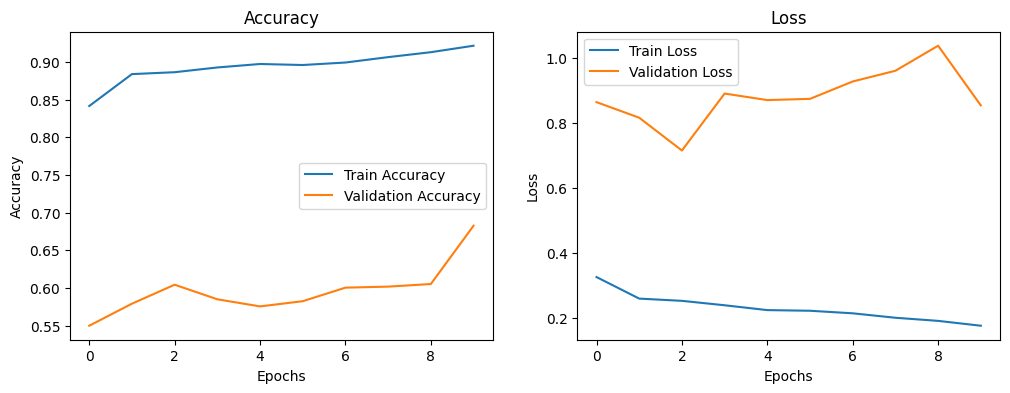

In [41]:
plot_training_history(history)

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Fonction de prédiction avec probabilités
def predict_image_binary_with_probabilities(model_save, image_path):
    img = load_img(image_path, target_size=(128, 128))  # Adapter la taille à celle du modèle
    img_array = img_to_array(img)  # Conversion en tableau numpy
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter la dimension batch
    img_array /= 255.0  # Normalisation de l'image

    # Prédiction binaire (probabilité unique)
    predictions = model_save.predict(img_array)
    probability = predictions[0][0]  # Probabilité que l'image soit une "Photo"
    
    # Classification basée sur la probabilité
    if probability > 0.7:
        predicted_class = 'Photo'
    else:
        predicted_class = 'Not-Photo'  # "Image" comme Not-Photo dans ce cas

    # Retourner la classe prédite et les probabilités (classe photo et non-photo)
    return predicted_class, [probability, 1 - probability]

# Fonction d'affichage des images avec probabilités
def display_images_with_binary_probabilities(model_save, dataset_dir, num_images=6):
    subfolders = ['Painting', 'Schematics', 'Sketch', 'Text']  # Liste des sous-dossiers d'images
    fig, axes = plt.subplots(2, num_images//2, figsize=(18, 8))  # Créer une grille pour afficher les images

    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']  # Extensions d'images valides

    for i in range(num_images):
        # Sélection aléatoire d'un sous-dossier
        subfolder = random.choice(subfolders)
        image_folder = os.path.join(dataset_dir, 'Image', subfolder)  # Chemin correct vers le sous-dossier

        # Vérifier l'existence du sous-dossier
        if not os.path.exists(image_folder):
            print(f"Folder not found: {image_folder}")
            continue
        
        try:
            # Fichiers valides dans le sous-dossier
            valid_files = [f for f in os.listdir(image_folder) if os.path.splitext(f)[1].lower() in valid_extensions]
            
            if len(valid_files) == 0:
                print(f"No valid image files found in: {image_folder}")
                continue

            random_image = random.choice(valid_files)
            image_path = os.path.join(image_folder, random_image)

            # Charger l'image et obtenir la prédiction
            img = load_img(image_path, target_size=(256, 256))  # Pour une meilleure visibilité
            predicted_class, probabilities = predict_image_binary_with_probabilities(model_save, image_path)

            # Sélectionner l'emplacement dans la grille (axes)
            ax = axes[i // (num_images // 2), i % (num_images // 2)]
            ax.imshow(img)
            ax.axis('off')

            # Afficher la classe prédite et le pourcentage
            probability_photo = probabilities[0] * 100  # Probabilité que ce soit une "Photo"
            ax.set_title(f'Predicted Class: {predicted_class} ({probability_photo:.2f}%)', fontsize=12)

        except Exception as e:
            print(f"An error occurred: {e}")
            ax.text(0.5, 0.5, 'Image Not Found', horizontalalignment='center', verticalalignment='center', fontsize=14)
            ax.axis('off')
            continue

    plt.tight_layout()
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
An error occurred: index 2 is out of bounds for axis 0 with size 2


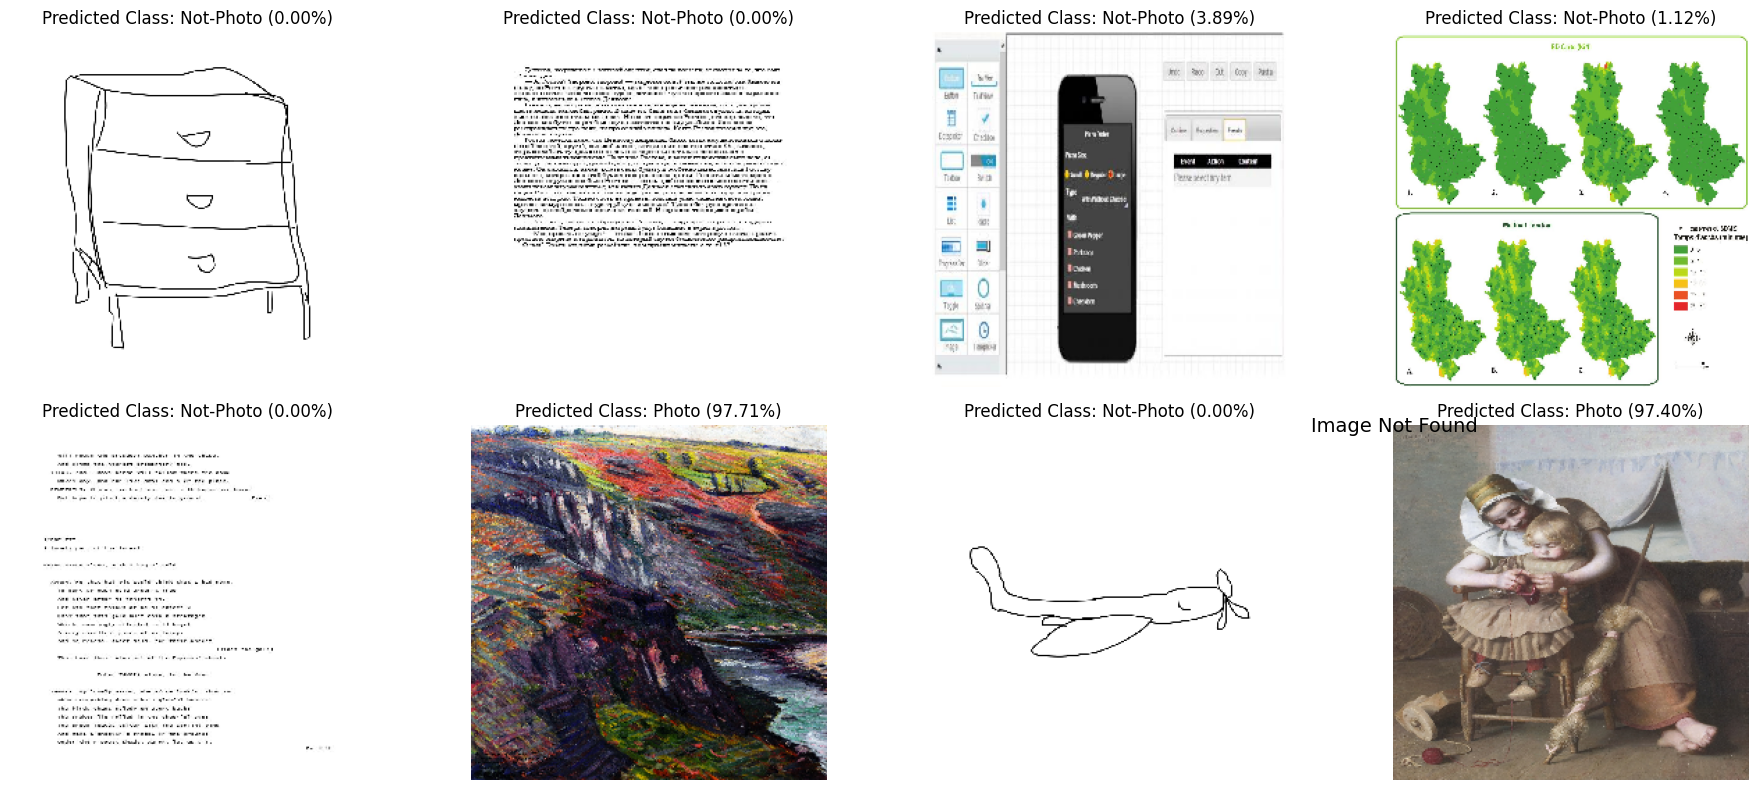

In [56]:
display_images_with_binary_probabilities(model, dataset_dir, num_images=9)

# Utilisation des Poids Sauvegarder


In [44]:
model_save_weights = Sequential()

In [45]:
model_save_weights.add(layers.Rescaling(1./255, input_shape=(128, 128, 3)))
model_save_weights.add(Conv2D(32, (3, 3), activation='relu'))
model_save_weights.add(MaxPooling2D(pool_size=(2, 2)))

model_save_weights.add(Conv2D(64, (3, 3), activation='relu'))
model_save_weights.add(MaxPooling2D(pool_size=(2, 2)))

model_save_weights.add(Conv2D(128, (3, 3), activation='relu'))
model_save_weights.add(MaxPooling2D(pool_size=(2, 2)))

model_save_weights.add(Flatten())
model_save_weights.add(Dense(128, activation='relu'))
model_save_weights.add(Dropout(0.5)) 
model_save_weights .add(Dense(64, activation='relu'))


model_save_weights.add(Dense(1, activation='sigmoid'))

c:\Users\steve\Documents\GitHub\DataSciencePictureDesc\data-science-env\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
model_save_weights.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
model_save_weights.load_weights('model.weights.h5')

c:\Users\steve\Documents\GitHub\DataSciencePictureDesc\data-science-env\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Contents of c:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\data_set_livrable_1\Image\Sketch: ['000_1_1_sz1.jpg', '001_1_1_sz1.jpg', '002_1_1_sz1.jpg', '003_1_1_sz1.jpg', '004_1_1_sz1.jpg', '005_1_1_sz1.jpg', '006_1_1_sz1.jpg', '007_1_1_sz1.jpg', '008_1_1_sz1.jpg', '009_1_1_sz1.jpg', '010_1_1_sz1.jpg', '011_1_1_sz1.jpg', '012_1_1_sz1.jpg', '013_1_1_sz1.jpg', '016_1_1_sz1.jpg', '017_1_1_sz1.jpg', '018_1_1_sz1.jpg', '019_1_1_sz1.jpg', '020_1_1_sz1.jpg', '021_1_1_sz1.jpg', '022_1_1_sz1.jpg', '023_1_1_sz1.jpg', '024_1_1_sz1.jpg', '025_1_1_sz1.jpg', '026_1_1_sz1.jpg', '027_1_1_sz1.jpg', '028_1_1_sz1.jpg', '029_1_1_sz1.jpg', '030_1_1_sz1.jpg', '031_1_1_sz1.jpg', '032_1_1_sz1.jpg', '033_1_1_sz1.jpg', '034_1_1_sz1.jpg', '035_1_1_sz1.jpg', '036_1_1_sz1.jpg', '037_1_1_sz1.jpg', '038_1_1_sz1.jpg', '039_1_1_sz1.jpg', '040_1_1_sz1.jpg', '041_1_1_sz1.jpg', '042_1_1_sz1.jpg', '043_1_1_sz1.jpg', '044_1_1_sz1.jpg', '045_1_1_sz1.jpg', '046_1_1_sz1.jpg', '047_1_1_sz1.jpg', '048_1_1_sz1.jp

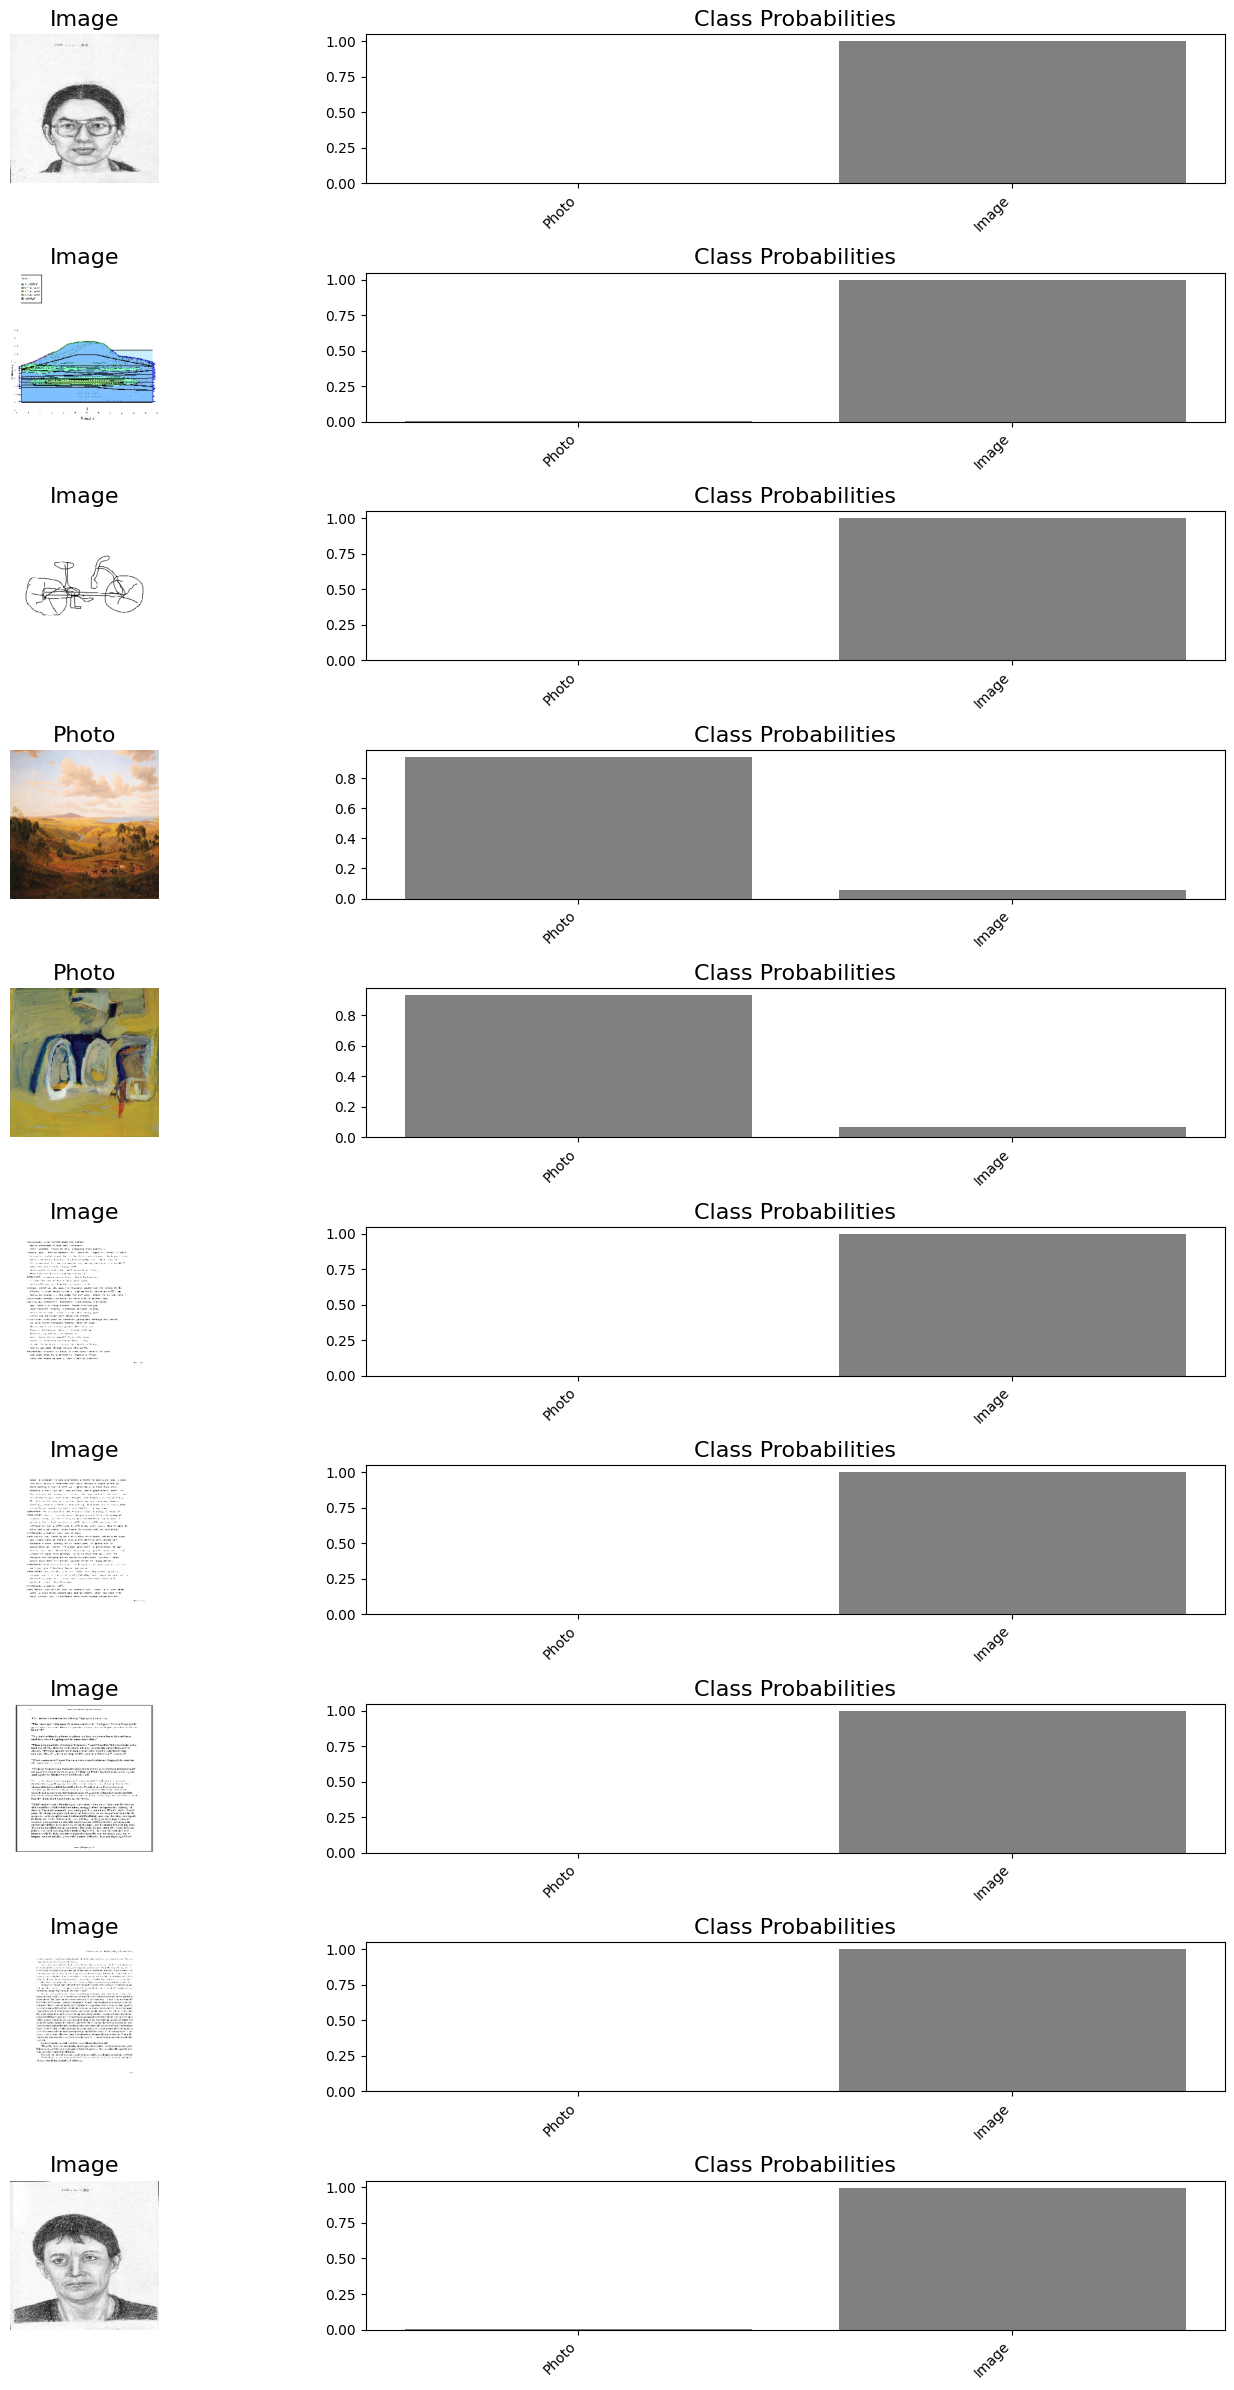

In [48]:
display_images_with_binary_probabilities(model_save_weights, dataset_dir, num_images=10)